# Get pattern

In [1]:
from PIL import Image
import torch
import numpy
img = Image.open("./data/Retro-Patterns-2--Arvin61r58_s.png")
def PIL2array(img):
    return numpy.array(img.getdata(),
                    numpy.uint8).reshape(img.size[1], img.size[0], 3)
im=PIL2array(img)

## Plot all patterns

<IPython.core.display.Javascript object>


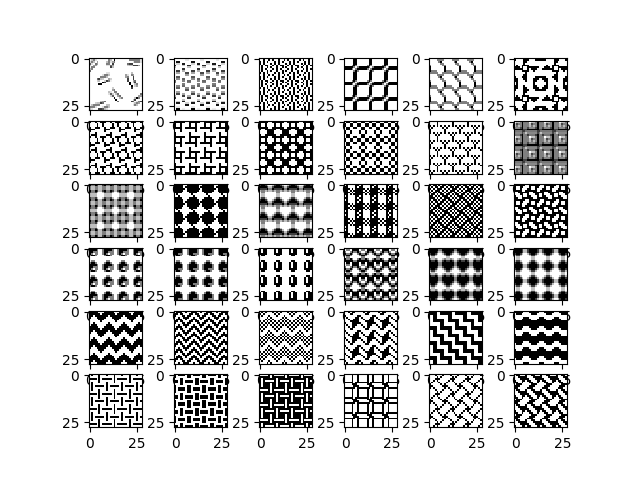

In [2]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook

fig, axs = plt.subplots(6, 6)

patterns = []

for i,j in [(i,j) for i in range(6) for j in range(6)]:

    x_i = random.randint(0, 5)
    y_i = random.randint(0, 5)
    
    xx_i = 32 * i + 6 * ( i + 1 )
    yy_i = 32 * j + 6 * ( j + 1 )
    
    pattern = im[xx_i+2:xx_i+32-2,yy_i+2:yy_i+32-2,1]/255.
    patterns.append(pattern)
    
    axs[i, j].imshow(pattern, cmap="gray")


# Make batches

In [3]:
#_range = [(i,j) for i in range(6) for j in range(6)]
#
#test_batches = []
#training_batches = []
#
#patterns = []
#for k,l in _range:
#    
#    xx_i = 32 * k + 6 * ( k + 1 )
#    yy_i = 32 * l + 6 * ( l + 1 )
#
#    pattern = im[xx_i+2:xx_i+32-2,yy_i+2:yy_i+32-2,1]/255.
#    patterns.append(torch.FloatTensor(pattern).unsqueeze(0).unsqueeze(0))
#    
#test_batches.append(torch.cat(patterns))
#for i,j in _range:
#    patterns = []
#    xx_i = 32 * i + 6 * ( i + 1 )
#    yy_i = 32 * j + 6 * ( j + 1 )
#    
#    im_u = im[xx_i+2:xx_i+32-2,yy_i+2:yy_i+32-2,1]/255.
#    
#    for k,l in _range:
#    
#        xx_i = 32 * k + 6 * ( k + 1 )
#        yy_i = 32 * l + 6 * ( l + 1 )
#    
#        pattern = im[xx_i+2:xx_i+32-2,yy_i+2:yy_i+32-2,1]/255.
#            pattern[0:15,:] = im_u[0:15,:]
#        
#        patterns.append(torch.FloatTensor(pattern).unsqueeze(0).unsqueeze(0))
#    
#    test_batches.append(torch.cat(patterns))
#    
#for idx,batch in enumerate(test_batches):
#    training_batches.append(batch.clone())
#training_batches[1][-1,0,:,:] = test_batches[0][-1,0,:,:]

from random import shuffle
import math
mixed = []
for idx, pattern1 in enumerate(patterns):
    for jdx, pattern2 in enumerate(patterns):
        if idx==jdx:
            continue
        pattern = pattern1.copy()
        pattern[0:15, :] = pattern2[0:15, :]
        mixed.append(pattern)

shuffle(mixed)
training = mixed[0:int(1260/2)]
test = mixed[int(1260/2):-1]
training_batches = []
test_batches = []
training_batches.append(torch.stack(torch.FloatTensor(patterns)).unsqueeze(1))
for i in range(math.ceil(len(training)/32)):
    training_batches.append(torch.stack(torch.FloatTensor(training[i*32:i*32+32])).unsqueeze(1))
test_batches.append(torch.stack(torch.FloatTensor(patterns)).unsqueeze(1))
for i in range(math.ceil(len(test)/32)):
    test_batches.append(torch.stack(torch.FloatTensor(test[i*32:i*32+32])).unsqueeze(1))

## Plot batches

<IPython.core.display.Javascript object>


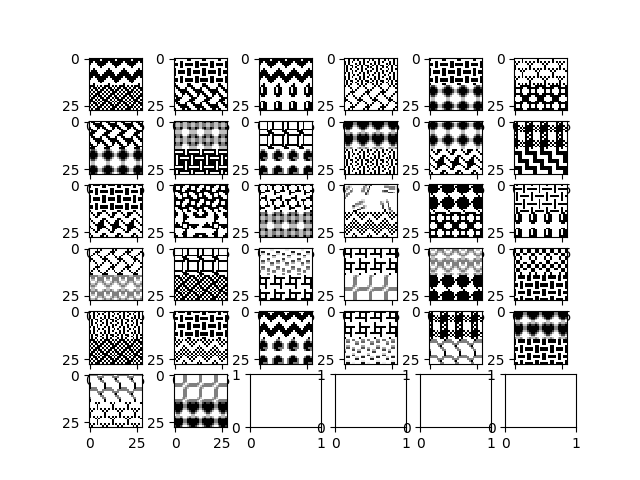

In [4]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook
_range = [(i,j) for i in range(6) for j in range(6)]
fig, axs = plt.subplots(6, 6)

for idx, (i,j) in enumerate(_range):
    if idx>31:
        continue
    pattern = training_batches[2][idx]
    
    axs[i, j].imshow(pattern[0], cmap="gray")

# Get AutoEncoder

In [100]:
import codes.VAE as VAE
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

vaes = []
for i in [2,4,6,8,10]:
    vae = VAE.VariationalAutoEncoder(i, 0, convolutional = True)
    vae.set_train_loader(training_batches, test_batches)
    vaes.append((i, vae))
    #vae.start()

<IPython.core.display.Javascript object>


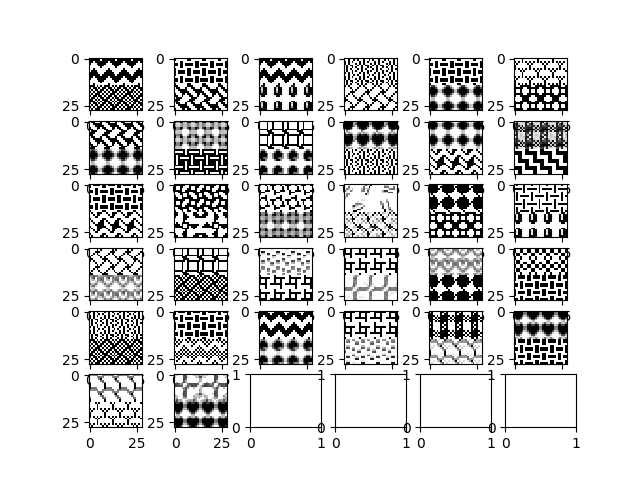

In [328]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook
_range = [(i,j) for i in range(6) for j in range(6)]
fig, axs = plt.subplots(6, 6)

for idx, (i,j) in enumerate(_range):
    if idx>31:
        break
    pattern = training_batches[2][idx]
    
    axs[i, j].imshow(vaes[4][1](Variable(pattern.unsqueeze(0)))[0,0,:,:].data, cmap="gray")

<IPython.core.display.Javascript object>


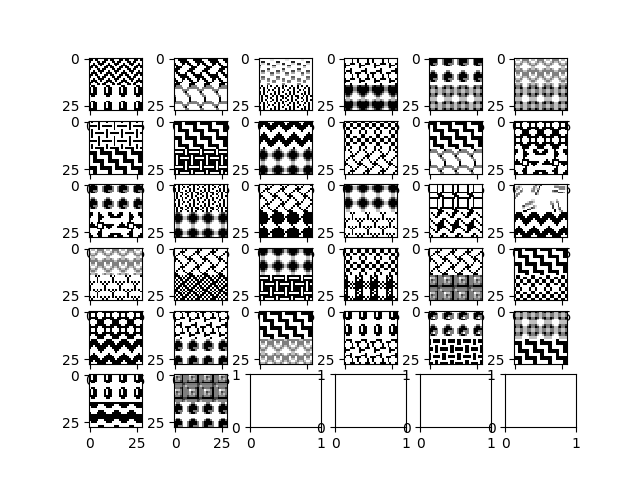

In [296]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook
_range = [(i,j) for i in range(6) for j in range(6)]
fig, axs = plt.subplots(6, 6)

for idx, (i,j) in enumerate(_range):
    if idx>31:
        break
    pattern = test_batches[2][idx]
    
    axs[i, j].imshow((Variable(pattern.unsqueeze(0)))[0,0,:,:].data, cmap="gray")

In [ ]:
import numpy as np
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
#np.random.seed(19680801)


fig, ax = plt.subplots()

resolution = 50  # the number of vertices
N = 3
x = np.random.randn(N)
y = np.random.randn(N)
radii = 0.5*np.random.rand(N)
patches = []
for _mu, _sigma in zip(mu, sigma):
    print(_mu,torch.exp(_sigma))
    circle = Circle(_mu.data, 0.25)
    patches.append(circle)


colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

plt.show()

<IPython.core.display.Javascript object>


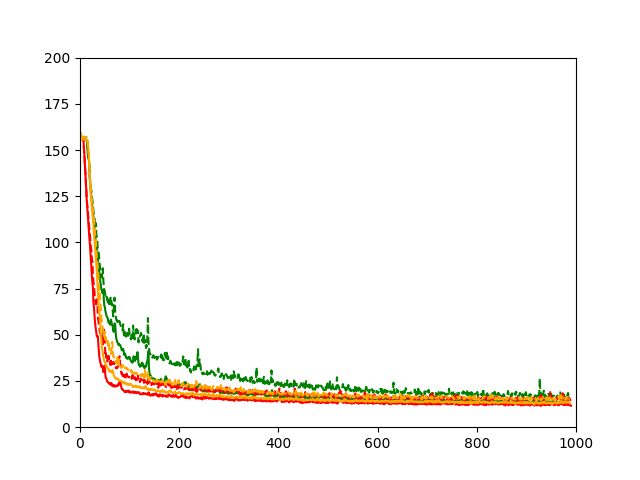

In [291]:
import matplotlib.pyplot as plt
import numpy
%matplotlib notebook

a_2 = numpy.array(vaes[0][1].get_progress())
a_4 = numpy.array(vaes[1][1].get_progress())
a_6 = numpy.array(vaes[2][1].get_progress())
a_8 = numpy.array(vaes[3][1].get_progress())
a_10 = numpy.array(vaes[4][1].get_progress())
plt.ylim(0, 200)
plt.xlim(0, 1000)
plt.plot(a_2[:,0],a_2[:,1],'b',a_2[:,0],a_2[:,2],'b--')
plt.plot(a_4[:,0],a_4[:,1],'g',a_4[:,0],a_4[:,2],'g--')
plt.plot(a_6[:,0],a_6[:,1],'r',a_6[:,0],a_6[:,2],'r--')
plt.plot(a_8[:,0],a_8[:,1],'yellow')
plt.plot(a_8[:,0],a_8[:,2],'yellow',linestyle='--')
plt.plot(a_10[:,0],a_10[:,1],'orange')
plt.plot(a_10[:,0],a_10[:,2],'orange',linestyle='--')

In [292]:
vaes[2][1].stop()

In [103]:
for i, vae in vaes:
    vae.stop()
    #print(i, vae.counter_epoch.value)

In [277]:
vaes[1][1].restart()

started False


In [ ]:
vaes[4][1].st

In [293]:
torch.save(vaes[2][1].state_dict(), "./data/saved_models/model_n6.trc")

In [334]:
from sympy import diff, log, symbols

In [336]:
x, y, z = symbols("x y z")

In [340]:
-2*(0.5*log(0.5))

0.693147180559945